# importing libraries

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
dataset_path = 'flights_2015.csv'
normalized_db = "normalized_airline_ops.db"

In [4]:
def create_normalized_schema(conn):
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Airlines (
        AIRLINE_IATA_CODE TEXT PRIMARY KEY,
        AIRLINE_NAME TEXT UNIQUE
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Airports (
        AIRPORT_IATA_CODE TEXT PRIMARY KEY,
        AIRPORT_NAME TEXT,
        CITY TEXT,
        STATE TEXT,
        COUNTRY TEXT,
        LATITUDE FLOAT64,
        LONGITUDE FLOAT64
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Flights (
        FLIGHT_ID INTEGER PRIMARY KEY AUTOINCREMENT, -- Corrected this line
        YEAR INT64,
        MONTH INT64,
        DAY INT64,
        DAY_OF_WEEK INT64,
        FLIGHT_NUMBER INT64,
        TAIL_NUMBER TEXT,
        SCHEDULED_DEPARTURE INT64,
        DEPARTURE_TIME INT64,
        DEPARTURE_DELAY FLOAT64,
        TAXI_OUT FLOAT64,
        WHEELS_OFF INT64,
        SCHEDULED_TIME FLOAT64,
        ELAPSED_TIME FLOAT64,
        AIR_TIME FLOAT64,
        DISTANCE FLOAT64,
        WHEELS_ON INT64,
        TAXI_IN FLOAT64,
        SCHEDULED_ARRIVAL INT64,
        ARRIVAL_TIME INT64,
        ARRIVAL_DELAY FLOAT64,
        DIVERTED INT64,
        CANCELLED INT64,
        CANCELLATION_REASON TEXT,
        AIR_SYSTEM_DELAY FLOAT64,
        SECURITY_DELAY FLOAT64,
        AIRLINE_DELAY FLOAT64,
        LATE_AIRCRAFT_DELAY FLOAT64,
        WEATHER_DELAY FLOAT64,
        AIRLINE_IATA_CODE TEXT,
        ORIGIN_AIRPORT_IATA_CODE TEXT,
        DESTINATION_AIRPORT_IATA_CODE TEXT,
        FOREIGN KEY (AIRLINE_IATA_CODE) REFERENCES Airlines(AIRLINE_IATA_CODE),
        FOREIGN KEY (ORIGIN_AIRPORT_IATA_CODE) REFERENCES Airports(AIRPORT_IATA_CODE),
        FOREIGN KEY (DESTINATION_AIRPORT_IATA_CODE) REFERENCES Airports(AIRPORT_IATA_CODE)
    )""")
    conn.commit()
    print("Normalized database schema created successfully.")

In [5]:
#populating our dataset using the schema we created
def populate_normalized_tables(conn, data):

    cursor = conn.cursor()

    #populating airlines table
    print("Populating Airlines table...")

    if 'AIRLINE_IATA_CODE' not in data.columns or 'AIRLINE_NAME' not in data.columns:
        raise ValueError("Missing 'AIRLINE_IATA_CODE' or 'AIRLINE_NAME'")

    airlines_data = data[['AIRLINE_IATA_CODE', 'AIRLINE_NAME']].drop_duplicates().dropna(subset=['AIRLINE_IATA_CODE'])
    try:
        cursor.executemany("INSERT OR IGNORE INTO Airlines (AIRLINE_IATA_CODE, AIRLINE_NAME) VALUES (?, ?)",
                           airlines_data.values.tolist())
        conn.commit()
        print(f"Airlines table populated with {len(airlines_data)} unique airlines.")
    except Exception as e:
        print(f"Error populating Airlines table: {e}")


    #populating airports table
    print("Populating Airports table...")

    origin_cols_expected = ['ORIGIN_AIRPORT', 'ORIGIN_AIRPORT_NAME', 'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_COUNTRY', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE']
    dest_cols_expected = ['DESTINATION_AIRPORT', 'DEST_AIRPORT_NAME', 'DEST_CITY', 'DEST_STATE', 'DEST_COUNTRY', 'DEST_LATITUDE', 'DEST_LONGITUDE']
    if not all(col in data.columns for col in origin_cols_expected) or \
       not all(col in data.columns for col in dest_cols_expected):
        raise ValueError("Missing one or more expected airport detail columns")

    origin_airports = data[origin_cols_expected].copy()
    origin_airports.columns = [
        'AIRPORT_IATA_CODE', 'AIRPORT_NAME', 'CITY', 'STATE',
        'COUNTRY', 'LATITUDE', 'LONGITUDE'
    ]

    dest_airports = data[dest_cols_expected].copy()
    dest_airports.columns = [
        'AIRPORT_IATA_CODE', 'AIRPORT_NAME', 'CITY', 'STATE',
        'COUNTRY', 'LATITUDE', 'LONGITUDE'
    ]

    all_airports = pd.concat([origin_airports, dest_airports]).drop_duplicates(subset=['AIRPORT_IATA_CODE']).dropna(subset=['AIRPORT_IATA_CODE'])
    all_airports = all_airports.groupby('AIRPORT_IATA_CODE').first().reset_index()

    try:
        cursor.executemany("""
            INSERT OR IGNORE INTO Airports (AIRPORT_IATA_CODE, AIRPORT_NAME, CITY, STATE, COUNTRY, LATITUDE, LONGITUDE)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, all_airports.values.tolist())
        conn.commit()
        print(f"Airports table populated with {len(all_airports)} unique airports.")
    except Exception as e:
        print(f"Error populating Airports table: {e}")

    #populating flights table
    print("Populating Flights table...")
    flight_cols = [
        'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME',
        'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL',
        'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED',
        'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
        'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
        'AIRLINE_IATA_CODE',
        'ORIGIN_AIRPORT',
        'DESTINATION_AIRPORT'
    ]

    actual_flight_cols = [col for col in flight_cols if col in data.columns]
    if len(actual_flight_cols) != len(flight_cols):
        missing = set(flight_cols) - set(actual_flight_cols)
        raise ValueError(f"Missing columns for Flights table: {missing}")

    flights_data_df = data[actual_flight_cols].copy()

    flights_data_df.rename(columns={
        'ORIGIN_AIRPORT': 'ORIGIN_AIRPORT_IATA_CODE',
        'DESTINATION_AIRPORT': 'DESTINATION_AIRPORT_IATA_CODE'
    }, inplace=True)

    flights_to_insert = [tuple(x) for x in flights_data_df.to_numpy()]

    batch_size = 50000
    total_inserted = 0
    col_names_for_insert = ", ".join(flights_data_df.columns)
    placeholders = ", ".join(["?"] * len(flights_data_df.columns))

    for i in range(0, len(flights_to_insert), batch_size):
        batch = flights_to_insert[i:i+batch_size]
        try:
            cursor.executemany(f"""
                INSERT INTO Flights ({col_names_for_insert})
                VALUES ({placeholders})
            """, batch)
            conn.commit()
            total_inserted += len(batch)
            print(f"Inserted {total_inserted}/{len(flights_to_insert)} flights...")
        except Exception as e:
            print(f"Error inserting batch into Flights table: {e}")
            break

    print(f"Flights table populated with {total_inserted} records.")
    print("Population of normalized tables complete.")


In [6]:
#running 5 queries to check details about our dataset
def run_stakeholder_queries_sql(conn):

    results_sql = {}

    #qn-1: The top 10 busiest flight routes?
    q1_sql = """
    SELECT
        O.AIRPORT_NAME AS OriginAirport,
        D.AIRPORT_NAME AS DestinationAirport,
        COUNT(F.FLIGHT_ID) AS NumberOfFlights
    FROM Flights F
    JOIN Airports O ON F.ORIGIN_AIRPORT_IATA_CODE = O.AIRPORT_IATA_CODE
    JOIN Airports D ON F.DESTINATION_AIRPORT_IATA_CODE = D.AIRPORT_IATA_CODE
    GROUP BY OriginAirport, DestinationAirport
    ORDER BY NumberOfFlights DESC
    LIMIT 10;
    """
    print("\nQ1: Top 10 Busiest Routes")
    results_sql['q1'] = pd.read_sql_query(q1_sql, conn)
    print(results_sql['q1'])

    #qn-2: The top 10 airlienes by average departure delay
    q2_sql = """
    SELECT
        A.AIRLINE_NAME,
        AVG(F.DEPARTURE_DELAY) AS AverageDepartureDelay
    FROM Flights F
    JOIN Airlines A ON F.AIRLINE_IATA_CODE = A.AIRLINE_IATA_CODE
    WHERE F.DEPARTURE_DELAY IS NOT NULL AND F.DEPARTURE_DELAY > 0
    GROUP BY A.AIRLINE_NAME
    ORDER BY AverageDepartureDelay DESC
    LIMIT 10;
    """
    print("\nQ2: Top 10 Airlines by Average Departure Delay (Positive Delays Only)")
    results_sql['q2'] = pd.read_sql_query(q2_sql, conn)
    print(results_sql['q2'])

    #qn-3: The day of the week having the highest average arrival delay?
    q3_sql = """
    SELECT
        CASE DAY_OF_WEEK
            WHEN 1 THEN 'Monday' WHEN 2 THEN 'Tuesday' WHEN 3 THEN 'Wednesday'
            WHEN 4 THEN 'Thursday' WHEN 5 THEN 'Friday' WHEN 6 THEN 'Saturday'
            WHEN 7 THEN 'Sunday' ELSE 'Unknown'
        END AS DayName,
        AVG(ARRIVAL_DELAY) AS AverageArrivalDelay
    FROM Flights
    WHERE ARRIVAL_DELAY IS NOT NULL
    GROUP BY DAY_OF_WEEK
    ORDER BY AverageArrivalDelay DESC;
    """
    print("\nQ3: Average Arrival Delay by Day of the Week")
    results_sql['q3'] = pd.read_sql_query(q3_sql, conn)
    print(results_sql['q3'])

    #qn-4: The top 5 airports having the most flight cancellations
    q4_sql = """
    SELECT
        A.AIRPORT_NAME AS OriginAirport,
        SUM(F.CANCELLED) AS TotalCancellations
    FROM Flights F
    JOIN Airports A ON F.ORIGIN_AIRPORT_IATA_CODE = A.AIRPORT_IATA_CODE
    WHERE F.CANCELLED = 1
    GROUP BY OriginAirport
    ORDER BY TotalCancellations DESC
    LIMIT 5;
    """
    print("\nQ4: Top 5 Origin Airports by Total Cancellations")
    results_sql['q4'] = pd.read_sql_query(q4_sql, conn)
    print(results_sql['q4'])

    #qn-5: The average scheduled flight time for the top 10 airlines?
    q5_sql = """
    SELECT
      A.AIRLINE_NAME,
      AVG(F.SCHEDULED_TIME) AS AverageScheduledDurationMinutes
    FROM Flights F
    JOIN Airlines A ON F.AIRLINE_IATA_CODE = A.AIRLINE_IATA_CODE
    WHERE F.SCHEDULED_TIME IS NOT NULL AND F.SCHEDULED_TIME > 0 -- Ensure valid scheduled time
    GROUP BY A.AIRLINE_NAME
    HAVING COUNT(F.FLIGHT_ID) > 1000 -- Only consider airlines with more than 1000 flights for a stable average
    ORDER BY AverageScheduledDurationMinutes DESC
    LIMIT 10;
    """
    print("\nQ5: Top 10 Airlines Average scheduled flight times: ")
    results_sql['q5'] = pd.read_sql_query(q5_sql, conn)
    print(results_sql['q5'])
    return results_sql


In [22]:
def run_stakeholder_queries_pandas(conn):

    print("\nExecuting Pandas Queries")

    # Load the normalized tables from SQLite into Pandas DataFrames
    df_flights_norm = pd.read_sql_query("SELECT * FROM Flights", conn)
    df_airlines_norm = pd.read_sql_query("SELECT * FROM Airlines", conn)
    df_airports_norm = pd.read_sql_query("SELECT * FROM Airports", conn)
    print(f"Loaded normalized tables into Pandas: Flights {df_flights_norm.shape}, Airlines {df_airlines_norm.shape}, Airports {df_airports_norm.shape}")

    results_pandas = {}

    # --- Pandas Q1: Top 10 Busiest Routes ---
    print("\nPandas Q1: Calculating Top 10 Busiest Routes...")
    merged_q1 = pd.merge(df_flights_norm, df_airports_norm, left_on='ORIGIN_AIRPORT_IATA_CODE', right_on='AIRPORT_IATA_CODE', suffixes=('', '_ORIG'))
    merged_q1 = pd.merge(merged_q1, df_airports_norm, left_on='DESTINATION_AIRPORT_IATA_CODE', right_on='AIRPORT_IATA_CODE', suffixes=('_ORIG', '_DEST'))
    route_counts = merged_q1.groupby(['AIRPORT_NAME_ORIG', 'AIRPORT_NAME_DEST'])['FLIGHT_ID'].count().reset_index(name='NumberOfFlights')
    
    # Rename columns to match SQL output for consistency
    route_counts.rename(columns={'AIRPORT_NAME_ORIG': 'OriginAirport', 
                                 'AIRPORT_NAME_DEST': 'DestinationAirport'}, inplace=True)
                                 
    results_pandas['q1'] = route_counts.sort_values(by='NumberOfFlights', ascending=False).head(10)
    print(results_pandas['q1'])

    # --- Pandas Q2: Top 10 Airlines by Average Departure Delay ---
    # ... (rest of the function remains the same) ...
    print("\nPandas Q2: Calculating Top 10 Airlines by Average Departure Delay...")
    merged_q2 = pd.merge(df_flights_norm, df_airlines_norm, on='AIRLINE_IATA_CODE')
    delayed_flights_q2 = merged_q2[(merged_q2['DEPARTURE_DELAY'].notna()) & (merged_q2['DEPARTURE_DELAY'] > 0)]
    avg_delay_q2 = delayed_flights_q2.groupby('AIRLINE_NAME')['DEPARTURE_DELAY'].mean().reset_index(name='AverageDepartureDelay')
    results_pandas['q2'] = avg_delay_q2.sort_values(by='AverageDepartureDelay', ascending=False).head(10)
    print(results_pandas['q2'])

    # --- Pandas Q3: Average Arrival Delay by Day of the Week ---
    print("\nPandas Q3: Calculating Average Arrival Delay by Day of the Week...")
    day_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    df_flights_norm['DAY_OF_WEEK'] = df_flights_norm['DAY_OF_WEEK'].astype(int)
    df_flights_norm_q3 = df_flights_norm[df_flights_norm['ARRIVAL_DELAY'].notna()].copy() 
    df_flights_norm_q3['DayName'] = df_flights_norm_q3['DAY_OF_WEEK'].map(day_map)
    avg_delay_q3 = df_flights_norm_q3.groupby('DayName')['ARRIVAL_DELAY'].mean().reset_index(name='AverageArrivalDelay')
    results_pandas['q3'] = avg_delay_q3.sort_values(by='AverageArrivalDelay', ascending=False)
    print(results_pandas['q3'])

    # --- Pandas Q4: Top 5 Origin Airports by Total Cancellations ---
    print("\nPandas Q4: Calculating Top 5 Origin Airports by Total Cancellations...")
    merged_q4 = pd.merge(df_flights_norm, df_airports_norm, left_on='ORIGIN_AIRPORT_IATA_CODE', right_on='AIRPORT_IATA_CODE')
    cancelled_flights_q4 = merged_q4[merged_q4['CANCELLED'] == 1]
    cancellations_q4 = cancelled_flights_q4.groupby('AIRPORT_NAME')['CANCELLED'].sum().reset_index(name='TotalCancellations')
    # Rename 'AIRPORT_NAME' to 'OriginAirport' to match SQL output for Q4
    cancellations_q4.rename(columns={'AIRPORT_NAME': 'OriginAirport'}, inplace=True)
    results_pandas['q4'] = cancellations_q4.sort_values(by='TotalCancellations', ascending=False).head(5)
    print(results_pandas['q4'])

    # --- Pandas Q5: Top 10 Airlines Average scheduled flight times ---
    print("\nPandas Q5: Calculating Top 10 Airlines Average scheduled flight times...")
    merged_q5_pd = pd.merge(df_flights_norm, df_airlines_norm, on='AIRLINE_IATA_CODE', how='inner')
    valid_flights_q5_pd = merged_q5_pd[
        (merged_q5_pd['SCHEDULED_TIME'].notna()) & (merged_q5_pd['SCHEDULED_TIME'] > 0)
    ]
    airline_stats_q5 = valid_flights_q5_pd.groupby('AIRLINE_NAME').agg(
        AverageScheduledDurationMinutes=('SCHEDULED_TIME', 'mean'),
        FlightCount=('FLIGHT_ID', 'count')
    ).reset_index()
    airlines_with_enough_data_q5 = airline_stats_q5[airline_stats_q5['FlightCount'] > 1000]
    results_pandas_q5 = airlines_with_enough_data_q5.sort_values(
        by='AverageScheduledDurationMinutes', ascending=False
    ).head(10)[['AIRLINE_NAME', 'AverageScheduledDurationMinutes']]
    results_pandas['q5'] = results_pandas_q5
    print(results_pandas['q5'])

    return results_pandas

In [28]:
def generate_visualizations(data_source_name, results_dict):

    print(f"\n--- Generating Visualizations for {data_source_name} Results ---")
    plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for aesthetics

    # --- Visualization for Q1: Top 10 Busiest Routes ---
    # Stacked or Grouped Horizontal Bar Chart:
    # Since a route has an origin and destination, a simple bar is fine.
    # Let's do an enhanced horizontal bar chart for readability of route names.
    if 'q1' in results_dict and not results_dict['q1'].empty:
        df_q1 = results_dict['q1'].copy()
        # Ensure consistent column names (assuming OriginAirport and DestinationAirport)
        if not ('OriginAirport' in df_q1.columns and 'DestinationAirport' in df_q1.columns):
            # Attempt to use _ORIG and _DEST if primary names are missing (e.g. if rename in pandas part was missed)
            if 'AIRPORT_NAME_ORIG' in df_q1.columns and 'AIRPORT_NAME_DEST' in df_q1.columns:
                df_q1.rename(columns={'AIRPORT_NAME_ORIG': 'OriginAirport',
                                      'AIRPORT_NAME_DEST': 'DestinationAirport'}, inplace=True)
            else:
                print(f"{data_source_name} - Q1: Missing expected 'OriginAirport' or 'DestinationAirport' columns.")
                return

        df_q1['Route'] = df_q1['OriginAirport'].fillna('UnknownOrigin') + '\n  to  \n' + df_q1['DestinationAirport'].fillna('UnknownDest')
        df_q1_viz = df_q1.sort_values(by='NumberOfFlights', ascending=True) # For horizontal bar

        if not df_q1_viz.empty:
            plt.figure(figsize=(12, 8))
            bars = plt.barh(df_q1_viz['Route'], df_q1_viz['NumberOfFlights'], color=sns.color_palette("mako", len(df_q1_viz)))
            plt.xlabel('Number of Flights', fontsize=12)
            plt.ylabel('Flight Route', fontsize=12)
            plt.title(f'{data_source_name} - Q1: Top 10 Busiest Flight Routes', fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=9) # Smaller font for potentially long route names

            for bar in bars:
                plt.text(bar.get_width() + 50, # Position label slightly to the right
                         bar.get_y() + bar.get_height()/2,
                         f'{int(bar.get_width()):,}',
                         va='center', ha='left', fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print(f"{data_source_name} - Q1: No data to visualize.")
    else:
        print(f"{data_source_name} - Q1: Data not available for visualization.")


    # --- Visualization for Q2: Top 10 Airlines by Average Departure Delay ---
    # Lollipop Chart (Kept as it's already quite good and not a basic bar)
    if 'q2' in results_dict and not results_dict['q2'].empty:
        df_q2 = results_dict['q2'].sort_values(by='AverageDepartureDelay', ascending=True)
        plt.figure(figsize=(12, 8))
        plt.hlines(y=df_q2['AIRLINE_NAME'], xmin=0, xmax=df_q2['AverageDepartureDelay'], color='skyblue', alpha=0.7, linewidth=3)
        plt.scatter(df_q2['AverageDepartureDelay'], df_q2['AIRLINE_NAME'], color='dodgerblue', s=100, alpha=0.9, zorder=3)

        for index, value in enumerate(df_q2['AverageDepartureDelay']):
            plt.text(value + 0.5, index, f"{value:.1f} min", va='center', fontsize=9)

        plt.title(f'{data_source_name} - Q2: Top 10 Airlines by Average Departure Delay (Lollipop Chart)', fontsize=16)
        plt.xlabel('Average Departure Delay (minutes)', fontsize=12)
        plt.ylabel('Airline', fontsize=12)
        plt.gca().xaxis.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{data_source_name} - Q2: Data not available for visualization.")


    # --- Visualization for Q3: Average Arrival Delay by Day of the Week ---
    # Radar Chart (Kept as it's good for cyclical data)
    if 'q3' in results_dict and not results_dict['q3'].empty:
        df_q3 = results_dict['q3'].copy()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        df_q3['DayName'] = pd.Categorical(df_q3['DayName'], categories=day_order, ordered=True)
        df_q3 = df_q3.sort_values('DayName').reset_index()

        labels = np.array(df_q3['DayName'])
        stats = df_q3['AverageArrivalDelay'].values

        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
        stats = np.concatenate((stats,[stats[0]])) # Close the plot
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, stats, color='mediumseagreen', linewidth=2, linestyle='solid')
        ax.fill(angles, stats, 'mediumseagreen', alpha=0.4)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_title(f'{data_source_name} - Q3: Average Arrival Delay by Day of the Week (Radar Chart)', size=16, y=1.1)
        ax.set_rlabel_position(30)
        plt.yticks(fontsize=10)
        ax.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{data_source_name} - Q3: Data not available for visualization.")


    # --- Visualization for Q4: Top 5 Origin Airports by Total Cancellations ---
    # Horizontal Bar Chart with Annotations (Kept - classic and effective)
    if 'q4' in results_dict and not results_dict['q4'].empty:
        df_q4 = results_dict['q4'].copy()
        # Ensure consistent column names
        if 'OriginAirport' not in df_q4.columns and 'AIRPORT_NAME' in df_q4.columns:
            df_q4.rename(columns={'AIRPORT_NAME': 'OriginAirport'}, inplace=True)
        elif 'OriginAirport' not in df_q4.columns:
            print(f"{data_source_name} - Q4: Missing 'OriginAirport' or 'AIRPORT_NAME' column.")
            return

        df_q4 = df_q4.sort_values(by='TotalCancellations', ascending=True)
        plt.figure(figsize=(10, 6))
        bars = plt.barh(df_q4['OriginAirport'], df_q4['TotalCancellations'], color=sns.color_palette("coolwarm_r", len(df_q4)))
        plt.xlabel('Total Cancellations', fontsize=12)
        plt.ylabel('Origin Airport', fontsize=12)
        plt.title(f'{data_source_name} - Q4: Top 5 Origin Airports by Total Cancellations', fontsize=16)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        for bar in bars:
            plt.text(bar.get_width() + 50,
                     bar.get_y() + bar.get_height()/2,
                     f'{int(bar.get_width()):,}',
                     va='center', ha='left', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{data_source_name} - Q4: Data not available for visualization.")


    #Qn-5
    if 'q5' in results_dict and not results_dict['q5'].empty:
        df_q5 = results_dict['q5'].sort_values(by='AverageScheduledDurationMinutes', ascending=False).copy() # Top values at the top

        plt.figure(figsize=(12, 8))
        # Create an ordered categorical type for the y-axis to ensure correct plotting order
        df_q5['AIRLINE_NAME_CAT'] = pd.Categorical(df_q5['AIRLINE_NAME'], categories=df_q5['AIRLINE_NAME'], ordered=True)

        plt.scatter(df_q5['AverageScheduledDurationMinutes'], df_q5['AIRLINE_NAME_CAT'],
                    color='purple', s=80, alpha=0.7, zorder=3)
        # Add horizontal lines from y-axis to dots (optional, for emphasis)
        for i in range(len(df_q5)):
            plt.hlines(y=df_q5['AIRLINE_NAME_CAT'].iloc[i], xmin=0, xmax=df_q5['AverageScheduledDurationMinutes'].iloc[i],
                       color='lightgray', alpha=0.5, linestyle='--', linewidth=1)
            plt.text(df_q5['AverageScheduledDurationMinutes'].iloc[i] + 3, # Offset text
                     df_q5['AIRLINE_NAME_CAT'].iloc[i],
                     f"{df_q5['AverageScheduledDurationMinutes'].iloc[i]:.1f} min",
                     va='center', fontsize=9)

        plt.title(f'{data_source_name} - Q5: Top 10 Airlines by Avg. Scheduled Flight Duration (Dot Plot)', fontsize=16)
        plt.xlabel('Average Scheduled Duration (minutes)', fontsize=12)
        plt.ylabel('Airline', fontsize=12)
        plt.gca().invert_yaxis() # To have the airline with the longest duration at the top
        plt.gca().xaxis.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{data_source_name} - Q5: Data not available for visualization.")

In [29]:
def main():
    overall_start_time = time.time()

    if os.path.exists(normalized_db):
        print(f"Removing existing database: {normalized_db}")
        os.remove(normalized_db)

    print(f"Loading data from {dataset_path}...")
    load_start_time = time.time()
    try:
        data = pd.read_csv(dataset_path, low_memory=False)
        print(f"Loaded {dataset_path} with shape {data.shape} in {time.time() - load_start_time:.2f} seconds.")
    except FileNotFoundError:
        print(f"Error: The CSV file '{dataset_path}' was not found.")
        return
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return

    conn = sqlite3.connect(normalized_db)
    print(f"Connected to database: {normalized_db}")

    create_normalized_schema(conn)
    populate_start_time = time.time()
    try:
        populate_normalized_tables(conn, data)
        print(f"Table population took {time.time() - populate_start_time:.2f} seconds.")
    except ValueError as ve:
        print(f"Error during table population: {ve}")
        conn.close()
        return
    except Exception as e:
        print(f"An unexpected error occurred during table population: {e}")
        conn.close()
        return
    del data

    sql_results = run_stakeholder_queries_sql(conn)
    pandas_results = run_stakeholder_queries_pandas(conn)

    print("\n--- Corroboration Summary ---")
    all_match = True
    for q_key in sql_results:
        if q_key in pandas_results:
            df_s = sql_results[q_key].copy()
            df_p = pandas_results[q_key].copy()
            for col in df_s.select_dtypes(include=np.number).columns:
                if col in df_p.columns and df_p[col].dtype == float:
                    df_s[col] = df_s[col].round(4)
                    df_p[col] = df_p[col].round(4)
            sort_cols = list(df_s.columns)
            try:
                for col in sort_cols:
                    if df_s[col].dtype != df_p[col].dtype:
                        if df_s[col].dtype == 'object' and df_p[col].dtype != 'object':
                            df_p[col] = df_p[col].astype(str)
                        elif df_p[col].dtype == 'object' and df_s[col].dtype != 'object':
                             df_s[col] = df_s[col].astype(str)
                df_s_sorted = df_s.sort_values(by=sort_cols).reset_index(drop=True)
                df_p_sorted = df_p.sort_values(by=sort_cols).reset_index(drop=True)
                if set(df_s_sorted.columns) == set(df_p_sorted.columns):
                     df_p_sorted = df_p_sorted[df_s_sorted.columns]
                if df_s_sorted.equals(df_p_sorted):
                    print(f"Query {q_key}: SQL and Pandas results MATCH (after sorting).")
                else:
                    all_match = False
                    print(f"Query {q_key}: SQL and Pandas results may DIFFER. Please inspect.")
            except TypeError as e_sort:
                all_match = False
                print(f"Query {q_key}: TypeError during sorting for comparison ({e_sort}). Comparing as is.")
                df_s_orig = sql_results[q_key].reset_index(drop=True)
                df_p_orig = pandas_results[q_key].reset_index(drop=True)
                if set(df_s_orig.columns) == set(df_p_orig.columns):
                    df_p_orig = df_p_orig[df_s_orig.columns]
                if df_s_orig.equals(df_p_orig):
                     print(f"Query {q_key}: SQL and Pandas results MATCH (original check).")
                else:
                     print(f"Query {q_key}: SQL and Pandas results may DIFFER (original check).")
            except Exception as e_comp:
                all_match = False
                print(f"Query {q_key}: Error during comparison ({e_comp}).")
    if all_match:
        print("\nAll query results successfully corroborated between SQL and Pandas (after sorting where applicable).")
    else:
        print("\nSome query results showed differences between SQL and Pandas implementations.")

    # --- Generate Visualizations for Pandas Results ---
    print("\n\nVISUALIZING PANDAS QUERY RESULTS")
    generate_visualizations("Pandas", pandas_results)

    # --- (Optional) Generate Visualizations for SQL Results for comparison ---
    # print("\n\n--- VISUALIZING SQL QUERY RESULTS ---")
    # generate_visualizations("SQL", sql_results)

    conn.close()
    print(f"\nDatabase connection closed. Total script execution time: {time.time() - overall_start_time:.2f} seconds.")

Removing existing database: normalized_airline_ops.db
Loading data from flights_2015.csv...
Loaded flights_2015.csv with shape (5819079, 44) in 16.53 seconds.
Connected to database: normalized_airline_ops.db
Normalized database schema created successfully.
Populating Airlines table...
Airlines table populated with 14 unique airlines.
Populating Airports table...
Airports table populated with 629 unique airports.
Populating Flights table...
Inserted 50000/5819079 flights...
Inserted 100000/5819079 flights...
Inserted 150000/5819079 flights...
Inserted 200000/5819079 flights...
Inserted 250000/5819079 flights...
Inserted 300000/5819079 flights...
Inserted 350000/5819079 flights...
Inserted 400000/5819079 flights...
Inserted 450000/5819079 flights...
Inserted 500000/5819079 flights...
Inserted 550000/5819079 flights...
Inserted 600000/5819079 flights...
Inserted 650000/5819079 flights...
Inserted 700000/5819079 flights...
Inserted 750000/5819079 flights...
Inserted 800000/5819079 flights.

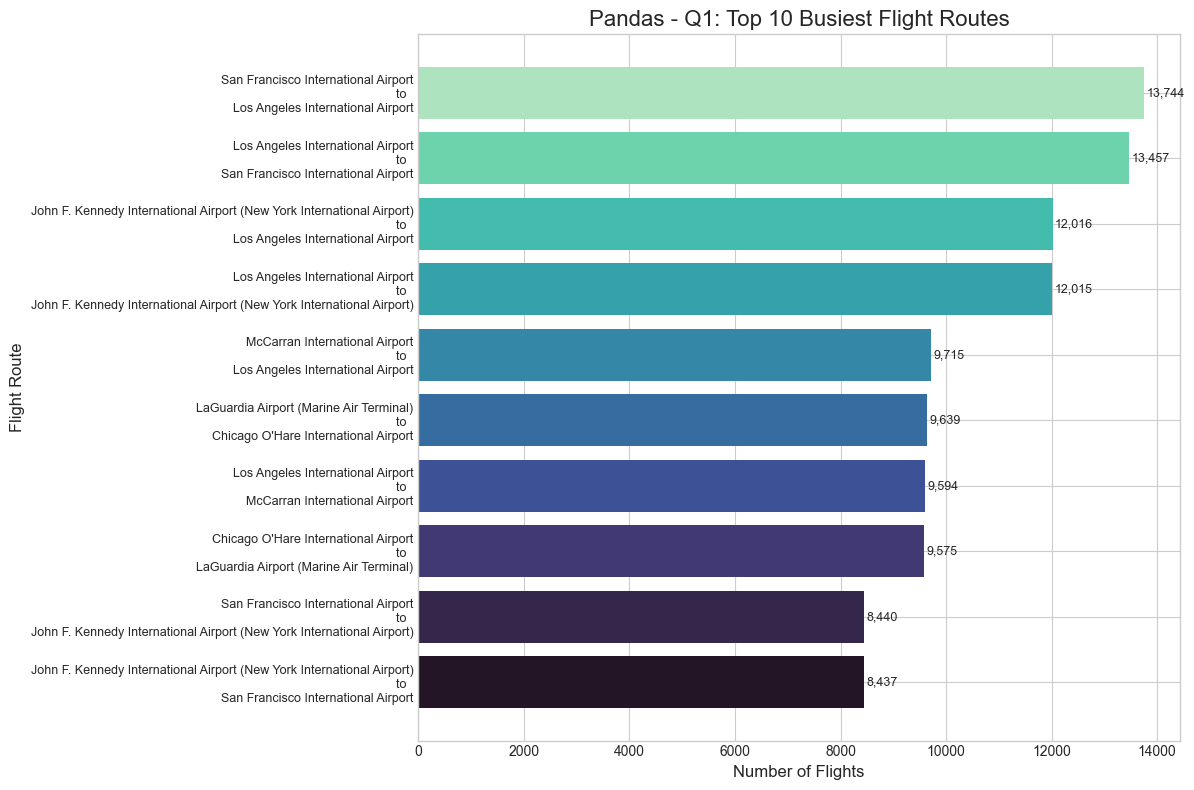

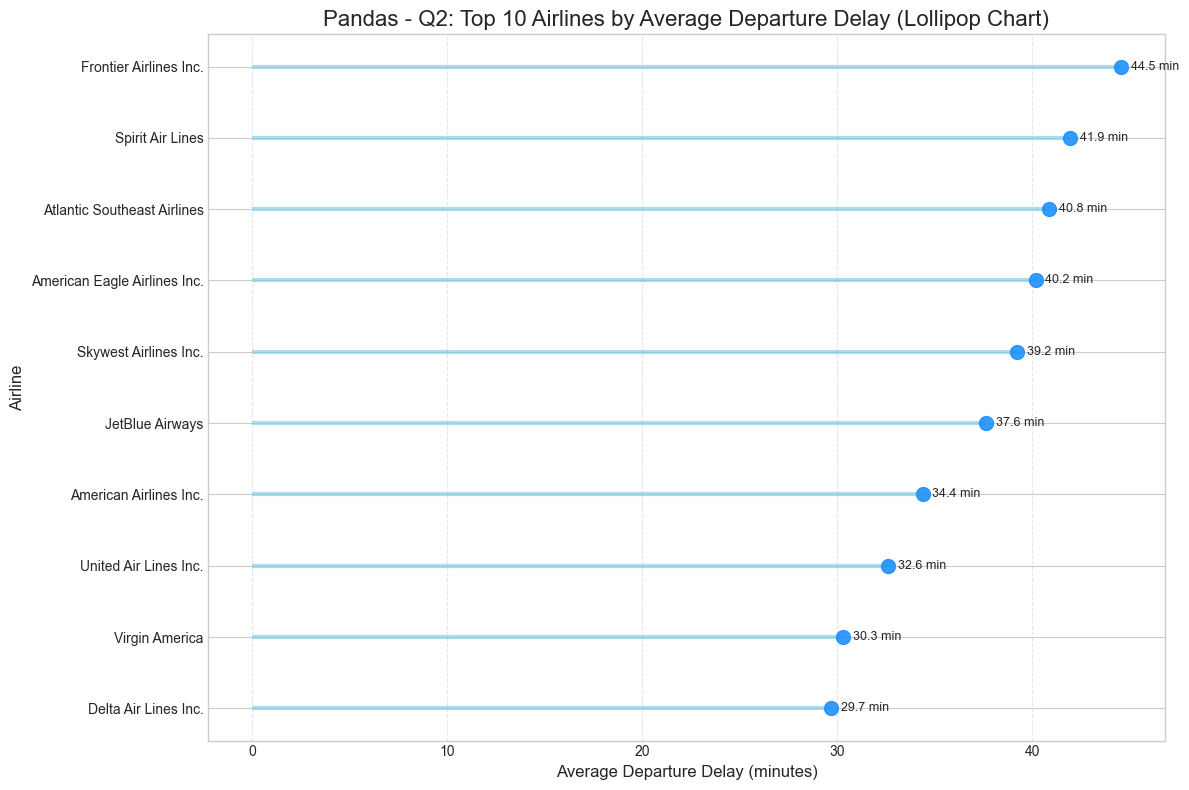

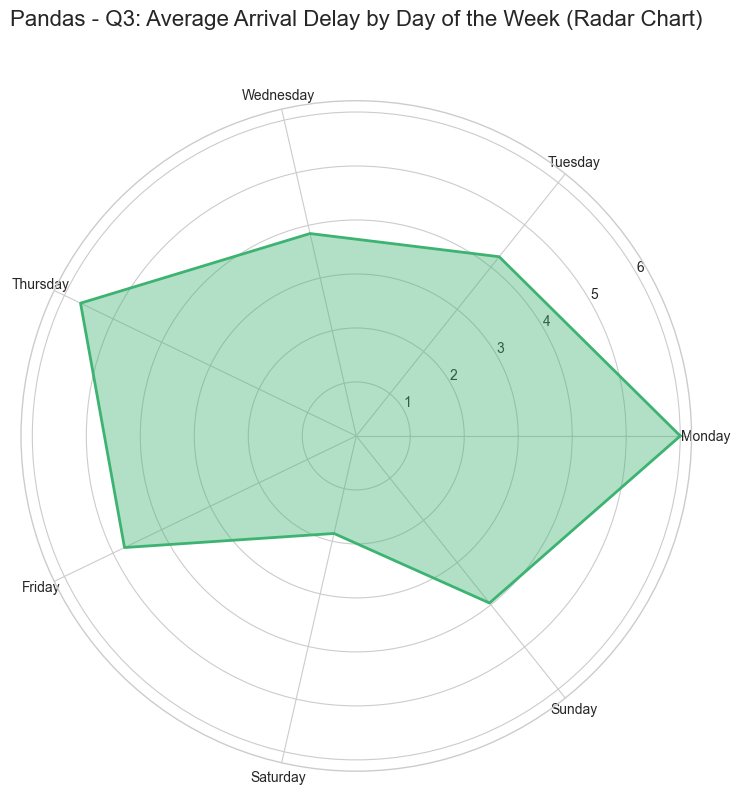

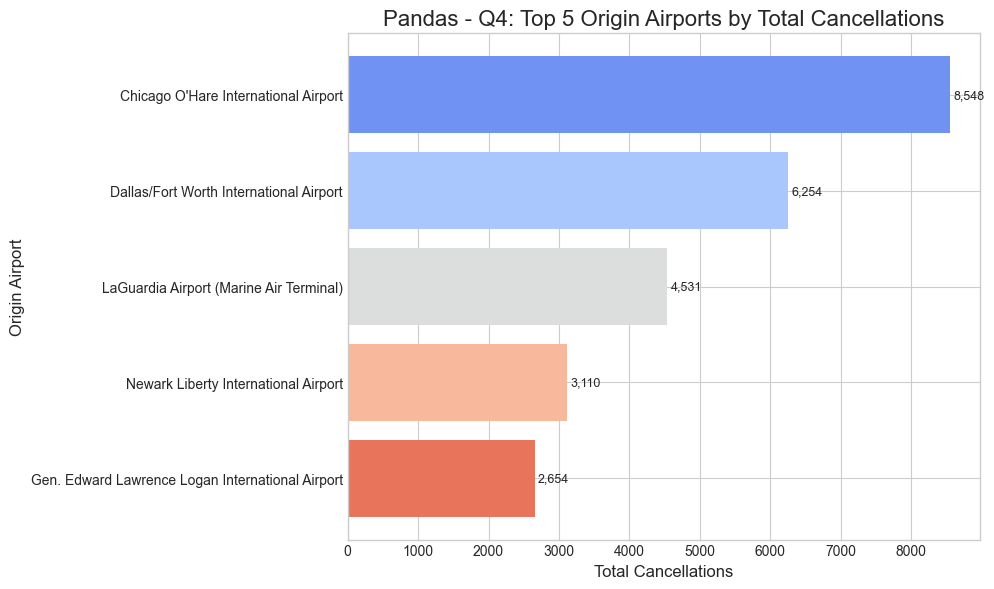

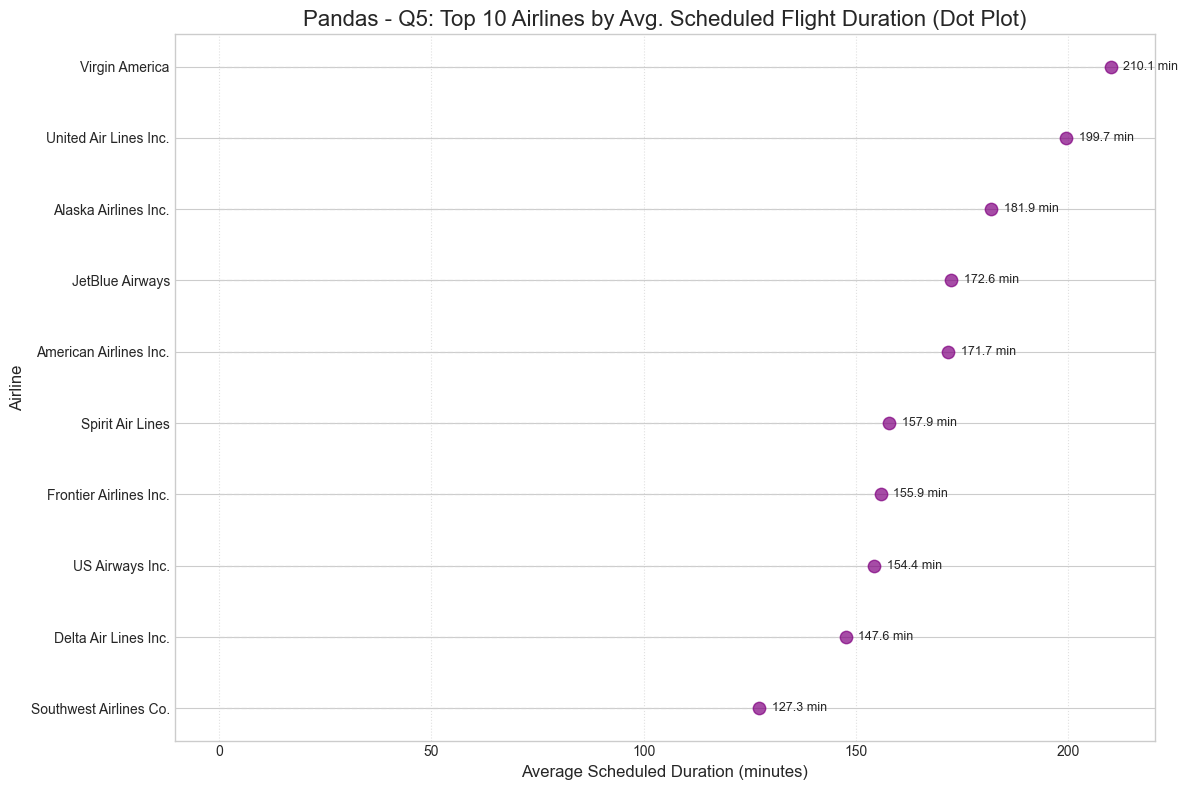


Database connection closed. Total script execution time: 76.11 seconds.


In [30]:
if __name__ == "__main__":
    if not os.path.exists(dataset_path):
        print(f"ERROR: The data file '{dataset_path}' was not found.")
        print("please make sure datafile is in the same directory as this script.")
    else:
        main()